In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3 #RGB channels
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "TOM",
    seed=32,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
len(class_names)

3

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 2 2 1 1 2 0 1 1 2 1 2 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 0 2]


In [6]:
len(dataset)

141

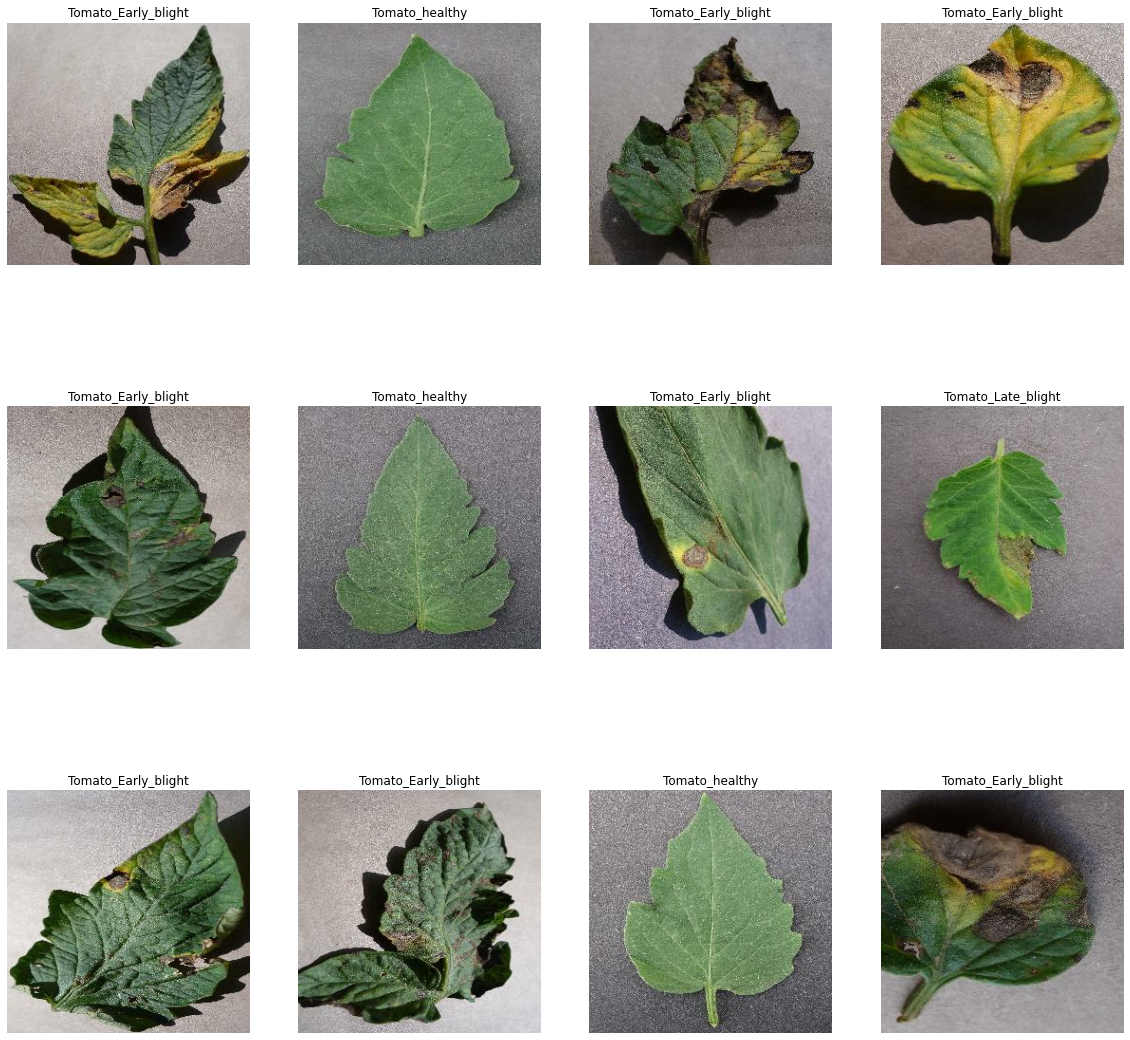

In [7]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

98

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 61504)              

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
98/98 [==============================] - 246s 2s/step - loss: 1.0212 - accuracy: 0.6547 - val_loss: 1.0688 - val_accuracy: 0.6424
Epoch 2/10
98/98 [==============================] - 210s 2s/step - loss: 0.4694 - accuracy: 0.7881 - val_loss: 0.5338 - val_accuracy: 0.7783
Epoch 3/10
98/98 [==============================] - 211s 2s/step - loss: 0.4030 - accuracy: 0.8201 - val_loss: 0.3482 - val_accuracy: 0.8095
Epoch 4/10
98/98 [==============================] - 209s 2s/step - loss: 0.3382 - accuracy: 0.8598 - val_loss: 0.3251 - val_accuracy: 0.8676
Epoch 5/10
98/98 [==============================] - 209s 2s/step - loss: 0.2780 - accuracy: 0.8787 - val_loss: 0.3516 - val_accuracy: 0.8557
Epoch 6/10
98/98 [==============================] - 208s 2s/step - loss: 0.2613 - accuracy: 0.8876 - val_loss: 0.5437 - val_accuracy: 0.8212
Epoch 7/10
98/98 [==============================] - 207s 2s/step - loss: 0.2828 - accuracy: 0.8876 - val_loss: 0.3955 - val_accuracy: 0.8512
Epoch 8/10
98

In [18]:
scores = model.evaluate(test_ds)

22/22 [==============================] - 15s 464ms/step - loss: 0.2025 - accuracy: 0.9162


In [19]:
scores

[0.20254921913146973, 0.9161931872367859]

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_healthy


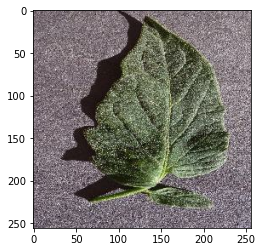

In [21]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


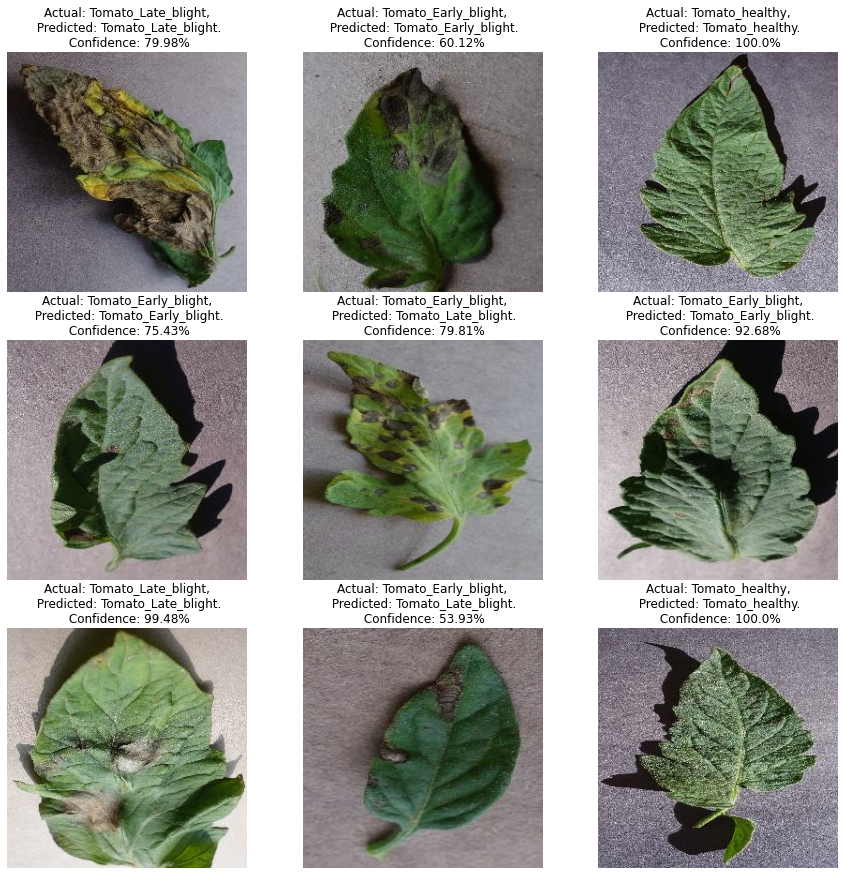

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")